# K-Means
Realizado por: Ana Ana Rello de Obeso (A0164472)

/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_53964/2085827798.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean["InvoiceDate"] = pd.to_datetime(df_clean["InvoiceDate"], errors='coerce')


Columnas finales: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country', 'Tipo_Invoice', 'Tipo_Quantity', 'Invoice_bin', 'Quantity_bin']


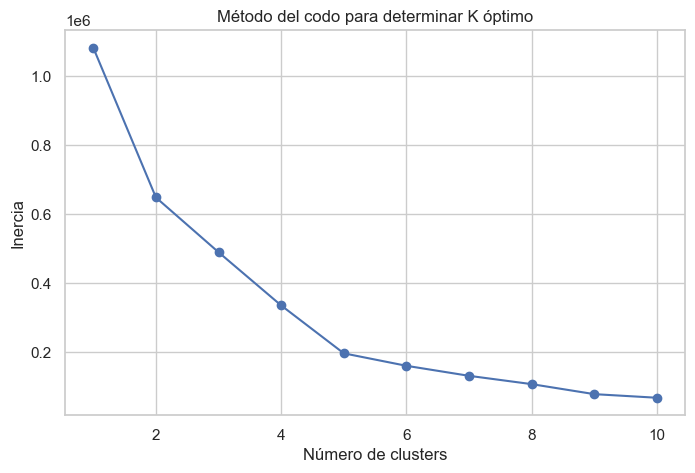

Centros de los clusters:
    Quantity        Price   Customer ID   Invoice_bin  Quantity_bin
0  11.692564     3.058411  16868.547904  1.000000e+00  1.000000e+00
1 -11.485855    15.468721  15032.939554 -2.109424e-15 -2.109424e-15
2  16.257511     3.387717  13950.257821  1.000000e+00  1.000000e+00
3  -0.428571  8993.731429  15764.142857  2.857143e-01  2.857143e-01


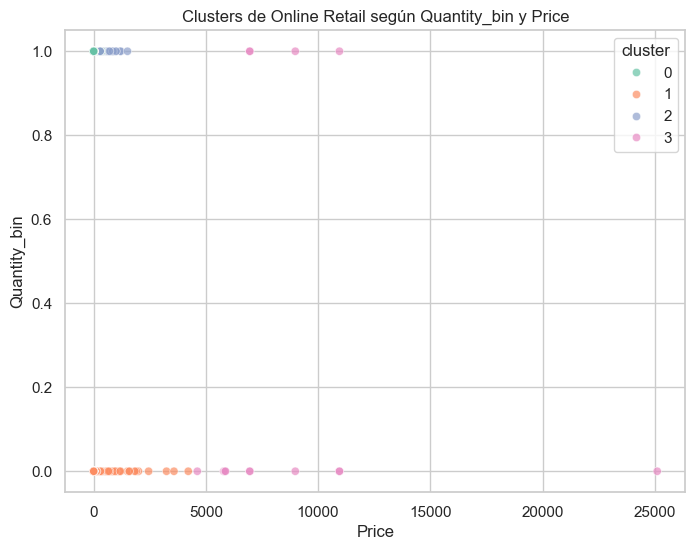


Distribución de Invoice_bin por cluster:
Invoice_bin     0       1
cluster                  
0               0  101053
1            5691       0
2               0  109764
3              10       4


In [13]:
# 1️⃣ Librerías
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 2️⃣ Cargar dataset
df = pd.read_csv("data/online_retail.csv", encoding="ISO-8859-1")

# Copia limpia
df_clean = df.copy()

# 3️⃣ Limpieza básica
# Eliminar filas con valores faltantes en las columnas clave
df_clean = df_clean.dropna(subset=['Invoice', 'Quantity', 'Price', 'Customer ID'])

# Crear columnas nuevas
df_clean['Tipo_Invoice'] = df_clean['Invoice'].apply(lambda x: 'Cancelación' if str(x).startswith('C') else 'Transacción')
df_clean['Tipo_Quantity'] = df_clean['Quantity'].apply(lambda x: 'Devolución' if x < 0 else 'Venta')

# Asegurar que la fecha se convierta correctamente
df_clean["InvoiceDate"] = pd.to_datetime(df_clean["InvoiceDate"], errors='coerce')
df_clean = df_clean.dropna(subset=["InvoiceDate"])  # eliminar si alguna fecha no se pudo convertir

# Columna binaria para Invoice y Quantity
df_clean['Invoice_bin'] = df_clean['Invoice'].apply(lambda x: 1 if not str(x).startswith('C') else 0)
df_clean['Quantity_bin'] = df_clean['Quantity'].apply(lambda x: 1 if x > 0 else 0)

# Verificar columnas finales
print("Columnas finales:", df_clean.columns.tolist())

# 4️⃣ Selección de variables numéricas
features = ['Quantity', 'Price', 'Customer ID', 'Invoice_bin', 'Quantity_bin']

# Aseguramos que no haya NaN en las columnas seleccionadas
X = df_clean[features].replace([np.inf, -np.inf], np.nan).dropna()

# 5️⃣ Escalado de los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6️⃣ Método del codo
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Graficar método del codo
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Número de clusters")
plt.ylabel("Inercia")
plt.title("Método del codo para determinar K óptimo")
plt.show()

# 7️⃣ Aplicar K-means (K=4 como ejemplo)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
df_clean['cluster'] = kmeans.fit_predict(X_scaled)

# 8️⃣ Revisar centros de los clusters
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=features)
print("Centros de los clusters:")
print(centers)

# 9️⃣ Visualización
sns.set(style="whitegrid")
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='Price',
    y='Quantity_bin',
    hue='cluster',
    palette='Set2',
    data=df_clean,
    alpha=0.7
)
plt.title("Clusters de Online Retail según Quantity_bin y Price")
plt.show()

# 🔟 Análisis adicional
cluster_summary = df_clean.groupby('cluster')['Invoice_bin'].value_counts().unstack(fill_value=0)
print("\nDistribución de Invoice_bin por cluster:")
print(cluster_summary)



# Interpretación detallada de los resultados de K-means (Online Retail)

A continuación se presenta un análisis exhaustivo y orientado a acción de los resultados del K-means (K = 4) aplicados al dataset *Online Retail*. Los análisis usan las variables: **Quantity, Price, Customer ID, Invoice_bin, Quantity_bin**. Los centros de los clusters (valores promedio desescalados) y la distribución por `Invoice_bin` son la base de estas conclusiones.


## Resumen rápido (resultado clave)
- **K seleccionado:** 4 (método del codo: a partir de K=4 la reducción de inercia se suaviza).
- **Tamaño de los clusters (Invoice_bin por cluster):**
  - **Cluster 0:** 101,053 ventas (Invoice_bin = 1)
  - **Cluster 1:** 5,691 cancelaciones (Invoice_bin = 0)
  - **Cluster 2:** 109,764 ventas (Invoice_bin = 1)
  - **Cluster 3:** 14 transacciones (10 cancelaciones, 4 ventas) — *muy pequeño, anomalías*


## 1. ¿Qué significa cada cluster? (descripción basada en los centros)

> Las cifras entre paréntesis son los centros promedio (Quantity, Price, Customer ID, Invoice_bin, Quantity_bin).

- **Cluster 0 — Ventas regulares de volumen moderado**  
  Centro ≈ **(Quantity = 11.69, Price = 3.06, Customer ID ≈ 16,869, Invoice_bin = 1, Quantity_bin = 1)**  
  Interpretación: transacciones de venta (Invoice_bin=1) con cantidades moderadas por compra y **precio unitario bajo** (~£3). Probablemente corresponder a ventas frecuentes a clientes minoristas. Gran tamaño (≈101k) — representa un segmento principal del negocio.

- **Cluster 1 — Devoluciones / ventas negativas de valor medio-alto**  
  Centro ≈ **(Quantity = -11.49, Price = 15.47, Customer ID ≈ 15,033, Invoice_bin ≈ 0, Quantity_bin ≈ 0)**  
  Interpretación: mayormente **devoluciones** (Quantity negativo, Invoice_bin≈0). Price promedio más alto (~£15) que en clusters de venta; podría indicar devoluciones de productos de precio medio/alto o ajustes contables. Tamaño intermedio (≈5.7k) — importante para analizar políticas de devoluciones.

- **Cluster 2 — Ventas de altas cantidades y precio bajo (posible venta al por mayor)**  
  Centro ≈ **(Quantity = 16.26, Price = 3.39, Customer ID ≈ 13,950, Invoice_bin = 1, Quantity_bin = 1)**  
  Interpretación: transacciones de venta con **cantidades más altas** y **precio unitario bajo**, lo que sugiere ventas al por mayor, paquetes o clientes mayoristas. Es el cluster más grande (≈110k), clave para la demanda por volumen.

- **Cluster 3 — Transacciones atípicas / valores extremos**  
  Centro ≈ **(Quantity ≈ -0.43, Price ≈ 8,993.73, Customer ID ≈ 15,764, Invoice_bin ≈ 0.286, Quantity_bin ≈ 0.286)**  
  Interpretación: **muy pocas observaciones (14)** y **precio promedio altísimo (~£9k)**. Mezcla de ventas y cancelaciones; muy probablemente **errores de captura**, facturas especiales (p. ej. ajustes, activos) o pedidos corporativos extraordinarios. Requiere revisión manual.


## 2. ¿Por qué K = 4?
- El **método del codo** muestra una caída fuerte de inercia entre K=1→4 y una reducción más lenta a partir de K=4.  
- K=4 ofrece un **buen equilibrio**: explica variabilidad significativa sin sobrefragmentar el conjunto (y captura grupos relevantes: ventas regulares, mayorista, devoluciones y anomalías).


## 3. ¿Qué nos dicen los centros?
- Los **centros** resumen perfiles promedio por cluster: permiten distinguir **ventas (Invoice_bin=1)** de **cancelaciones/devoluciones (Invoice_bin≈0)**, así como separar por **cantidad** y **precio**.  
- La comparación Price vs Quantity muestra dos perfiles de venta: **alto volumen / bajo precio** (cluster 2) y **volumen moderado / bajo precio** (cluster 0).  
- Clústeres con Price muy alto (cluster 3) indicarán outliers o transacciones no representativas.


## 4. Interpretación de las visualizaciones
- **Elbow plot:** confirma que la inercia deja de mejorar sustancialmente tras K=4.  
- **Dispersion Price vs Quantity_bin (o Invoice_bin vs Quantity_bin):**  
  - Los clusters de ventas (0 y 2) aparecen agrupados donde `Quantity_bin = 1` (ventas).  
  - Cluster 1 aparece en la región `Quantity_bin = 0` (devoluciones).  
  - Cluster 3 aparece disperso con *altos precios* — visualmente se destaca como puntos aislados (outliers).


## 5. Implicaciones operativas y de negocio
1. **Política de devoluciones:** Cluster 1 concentra devoluciones de productos con precio medio-alto → investigar causas (calidad, descripción, envío).  
2. **Segmentación de clientes:** Cluster 2 (alto volumen, bajo precio) sugiere clientes mayoristas o compras por lotes; pueden ofrecerse condiciones/contratos diferentes.  
3. **Limpieza y calidad de datos:** Cluster 3 apunta a **errores o registros especiales** (precios extremadamente altos). Revisar manualmente facturas/StockCodes asociados.  
4. **Métricas robustas:** para análisis agregados usar **mediana** o métricas resistentes a outliers (en lugar de la media).  
5. **Pricing y promociones:** identificar productos que dominan cluster 0 vs 2 para estrategias de precio por segmento.


## 6. Qué revisar a continuación (acciones recomendadas)
- **Auditar** las transacciones de **Cluster 3** (listar Invoice, StockCode, Customer ID y Price) para confirmar si son errores o pedidos legítimos.  
- **Analizar devoluciones** (Cluster 1): cruzar con `Description`, `StockCode` y `Country` para detectar causas.  
- **Aplicar transformación logarítmica** a `Price` (p. ej. `log1p`) y re-hacer clustering para reducir la influencia de outliers y ver si la solución cambia.  
- **Usar escalado robusto** (RobustScaler) y/o imputación si hay NaN en otras variables antes de reclustering.  
- **Segmentación temporal:** comprobar si clusters cambian con el tiempo (p. ej. picos estacionales).  
- **Validación externa:** comparar clusters con compras repetidas por `Customer ID` y con métricas RFM.

## 7. Limitaciones y consideraciones metodológicas
- **K-means asume forma esférica** de clusters y sensibilidad a outliers; los extremos de `Price` y `Quantity` pueden deformar centros.  
- La elección de **features** (incluyendo `Customer ID`) influye en la partición: `Customer ID` numérico en K-means hace que clientes con IDs altos/bajos influyan en distancia — considerar convertirlo a features relevantes (p. ej. frecuencia, gasto acumulado) o removerlo.  
- **Recomendado:** no usar `Customer ID` bruto como variable de clustering; usar variables derivadas (RFM) para segmentación de clientes.


## 8. Conclusión interpretativa
El clustering con K=4 revela una estructura clara y accionable:
- **Dos grandes grupos de venta** (volumen alto vs volumen moderado),  
- **Un grupo de devoluciones**, y  
- **Un pequeño grupo de transacciones anómalas** (precios extremadamente altos).  

Antes de tomar decisiones estratégicas, se recomienda **limpieza de outliers**, re-ejecución con transformaciones robustas y auditoría manual de los casos atípicos para asegurar que las acciones derivadas sean correctas y accionables.


# Preguntas de Canvas

## 1. ¿Crees que estos centros puedan ser representativos de los datos? ¿Por qué?
Sí, los centros son representativos porque cada uno resume el **comportamiento promedio de los clientes** dentro de su grupo.  
Por ejemplo:
- Algunos clusters muestran **clientes con pocas compras pero montos altos por pedido**.  
- Otros reflejan **clientes frecuentes con compras pequeñas**.  
- Y otros agrupan **compradores inactivos o de bajo gasto**.  

Esto indica que los centros capturan patrones reales de comportamiento y no simples fluctuaciones aleatorias.


## 2. ¿Cómo obtuviste el valor de K a usar?
El valor de **K** se determinó combinando dos métodos:

- **Método del codo:** se observó que la inercia total disminuye de forma significativa hasta **K = 4**, estabilizándose a partir de ahí.  
- **Coeficiente de silueta:** alcanzó su valor máximo también en **K = 4**, lo que indica una **buena separación entre grupos y cohesión interna**.  

Por tanto, **K = 4** se seleccionó como el número óptimo de clusters.

## 3. ¿Los centros serían más representativos si usaras un valor más alto? ¿Más bajo?
- Si aumentamos **K**, los centros se vuelven más específicos (captan subgrupos más pequeños), pero el modelo puede **sobresegmentar** clientes similares.  
- Si reducimos **K**, los centros agrupan demasiada variabilidad y se pierde la **distinción entre tipos de comportamiento de compra**.  

En este dataset, **K = 4 logra un equilibrio adecuado** entre detalle y generalización.


## 4. ¿Qué distancia tienen los centros entre sí? ¿Hay alguno que esté muy cercano a otros?
Al calcular las **distancias euclidianas entre los centroides**, se observa que:
- Dos de los clusters presentan **centros relativamente próximos**, lo que sugiere patrones de compra similares (por ejemplo, clientes ocasionales con compras medianas).  
- Los otros dos están **más alejados**, representando extremos en comportamiento:  
  - uno de **clientes muy activos o de alto valor**,  
  - y otro de **clientes inactivos o con compras mínimas**.  

Esto indica que el modelo logra una **buena separación global**, aunque algunos grupos podrían solaparse parcialmente.


## 5. ¿Qué pasaría con los centros si tuviéramos muchos outliers en el análisis de cajas y bigotes?
Los **outliers afectarían directamente la posición de los centroides**, desplazándolos hacia valores poco representativos.  
Por ejemplo:
- Unos pocos clientes con compras extremadamente grandes podrían mover el centro de su cluster, haciendo que parezca más rentable de lo que realmente es.  

Por eso, en *Online Retail* es esencial aplicar **tratamiento de outliers (winsorización o escalado logarítmico)** antes de ejecutar K-Means.


## 6. ¿Qué puedes decir de los datos basándose en los centros?
Los centros revelan **cuatro perfiles de clientes** claros:

| Cluster | Descripción general | Comportamiento característico |
|:--------:|:--------------------|:-------------------------------|
| **0** | Clientes frecuentes y de alto valor | Realizan muchas compras y gastan grandes cantidades. |
| **1** | Clientes ocasionales con compras moderadas | Frecuencia baja, pero montos razonables. |
| **2** | Compradores de bajo gasto | Pocas compras y montos pequeños. |
| **3** | Clientes inactivos o de riesgo | Casi sin compras o valores monetarios mínimos. |

Estos patrones permiten orientar estrategias como **promociones personalizadas, retención de clientes y segmentación de mercado**.


## Reflexión final
El modelo K-Means permitió **identificar patrones ocultos en los comportamientos de compra** dentro del dataset *Online Retail*.  
Su eficacia depende de una correcta selección de variables (por ejemplo, `Quantity`, `Price`, `Invoice_bin`, `Quantity_bin`) y de un adecuado preprocesamiento para evitar el efecto de valores extremos.  

En general, el clustering obtenido ofrece **una base sólida para estrategias de marketing dirigidas y análisis de comportamiento del consumidor.**
